Exploring the deep fields

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
from photometric_models import HG, HG12, HG1G2
from db import query

plt.style.use('science')

filters = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}
linestyles = {'g': "--", "r":"-.", "i":":", "z":"-"}


In [2]:
ddfs = {
    "ELAIS S1": {"el": 345.97, "eb": -43.18},
    "XMM-LSS": {"el": 31.04, "eb": -17.90},
    "Extended Chandra Deep Field-South": {"el": 40.29, "eb": -45.47	},
    "COSMOS": {"el": 150.70, "eb":  -9.39}
} # https://www.lsst.org/scientists/survey-design/ddf #

In [3]:
objs = query(
    '''
    SELECT ssObjectId FROM dp03_catalogs_10yr.SSObject as sso WHERE numObs >= 2000
    '''
).to_table().to_pandas()

In [5]:
objs_detections = query(
    f'''
    SELECT eclipticLambda, eclipticBeta, ssObjectId FROM dp03_catalogs_10yr.SSSource as sss WHERE sss.ssObjectId IN {tuple(objs["ssObjectId"].to_list())}
    '''
).to_table().to_pandas()

In [37]:
objs_detections.to_csv("./high_objs_detections_coords.csv")

Text(0, 0.5, 'Ecliptic beta [deg]')

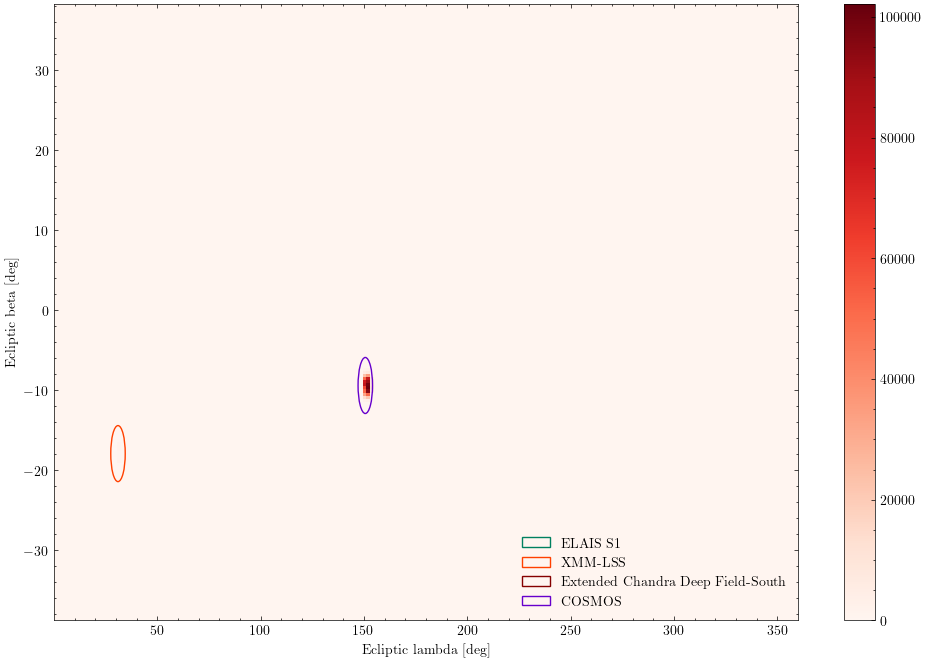

In [6]:
fig, ax = plt.subplots(figsize=(12,8))

h = ax.hist2d(
    objs_detections["eclipticLambda"],
    objs_detections["eclipticBeta"],
    bins=200,
    cmap=mpl.colormaps['Reds']
)
fig.colorbar(h[3], ax=ax)


for i, (ddf, coord) in enumerate(ddfs.items()):
    ax.add_patch(
        plt.Circle((coord["el"], coord["eb"]), 3.5, label=ddf, facecolor="none", edgecolor=list(filter_colors.values())[i])
    )

plt.legend(loc="lower right")
plt.xlabel(
    "Ecliptic lambda [deg]"
)
plt.ylabel(
    "Ecliptic beta [deg]"
)

In [9]:
# For each observation, is this in a deep drilling field?

# Is the ecliptic co-ord within 3.5 deg of x and y

def ddf_distance(field, el, eb):
    return np.sqrt((ddfs[field]["el"] - el)**2 + (ddfs[field]["eb"] - eb)**2)

def check_in_ddf(el, eb):
    for ddf, coords in ddfs.items():
        d = np.sqrt((coords["el"] - el)**2 + (coords["eb"] - eb)**2)
        if d <= 3.5:
            return True
    return False

count = 0
for i in range(len(objs_detections)):
    if check_in_ddf(el = objs_detections.iloc[i]["eclipticLambda"], eb=objs_detections.iloc[i]["eclipticBeta"]):
        count +=1

count

1059640

In [57]:
print(f"{count} object observations from the highly observed object detections are discovered in deep fields, that is {round(100*count/len(objs_detections),2)}% of these object's observations")

1059640 object observations from the highly observed object detections are discovered in deep fields, that is 87.16% of these object's observations


What about the other 13%?

In [16]:
for FIELD in ddfs:
    objs_detections[f"{FIELD}_distance"] = ddf_distance(field=FIELD, el = objs_detections["eclipticLambda"], eb = objs_detections["eclipticBeta"])
    objs_detections[f"in_{FIELD}"] =  objs_detections[f"{FIELD}_distance"] <= 3.5

In [21]:
for FIELD in ddfs:
    print(f'{objs_detections[f"in_{FIELD}"].sum()} in {FIELD}')

0 in ELAIS S1
22713 in XMM-LSS
0 in Extended Chandra Deep Field-South
1036927 in COSMOS


In [50]:
objs_detections["in_any_field"] = objs_detections["in_COSMOS"] + objs_detections["in_XMM-LSS"] + objs_detections["in_Extended Chandra Deep Field-South"] + objs_detections["in_ELAIS S1"]

In [67]:
x = objs_detections.groupby("ssObjectId")
print(f'{(x["in_any_field"].sum() == 0).sum()} objects have zero detections in the deep field.')
# All have at least one observation in the deep fields.

0 objects have zero detections in the deep field.


Orbital elements of these objects

In [111]:
obj_orbital_elements = query(
    f'''
    SELECT q/(1-e) as a, q, incl, e FROM  dp03_catalogs_10yr.MPCORB as mpc WHERE ssObjectId IN {tuple(objs["ssObjectId"].to_list())}

    '''
).to_table().to_pandas()

Text(0, 0.5, 'incl [deg]')

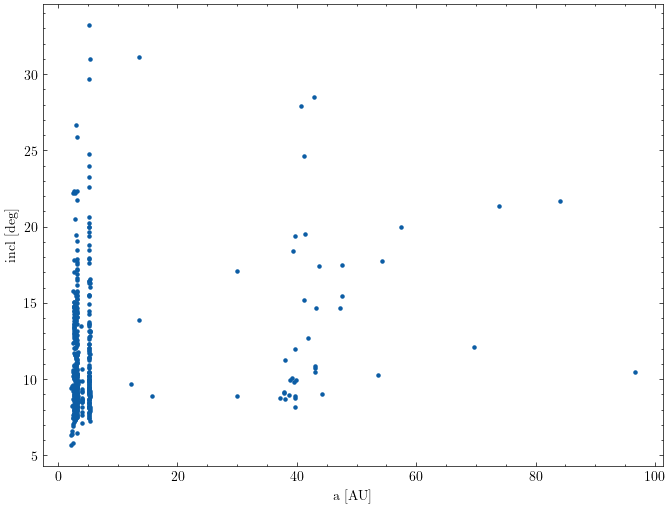

In [120]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(
    obj_orbital_elements["a"].astype(float),
    obj_orbital_elements["incl"].astype(float),
    s=5
)
ax.set_xlabel("a [AU]")
ax.set_ylabel("incl [deg]")

Text(0, 0.5, 'incl [deg]')

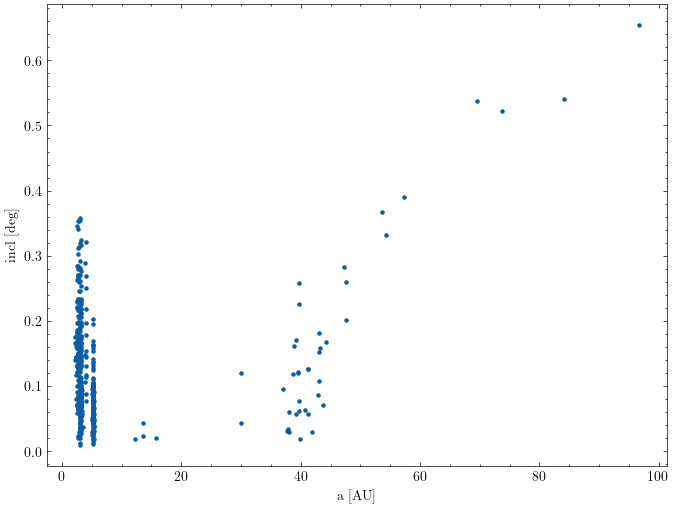

In [121]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(
    obj_orbital_elements["a"].astype(float),
    obj_orbital_elements["e"].astype(float),
    s=5
)
ax.set_xlabel("a [AU]")
ax.set_ylabel("incl [deg]")